In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry


In [2]:
# SPIRE channels
lambdas = [250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5)}
boxsize = {250:51, 350:39, 500:27}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results/'

zbins = [(0.1, 1.), (1., 5.0)]
# zbins = [(0.1, 1.), (1.,2.), (2.,3.), (3.,4.)]#, (4.,5.)]

rmax = 9

In [3]:
bkd = {}
sims = {}
for lambda_ in lambdas:
    bkd[lambda_] = {}
    sims[lambda_] = {}
    # Loop over patches
    for patch in patches:
            bkd[lambda_][patch] = {}
            sims[lambda_][patch] = {}
            for idz, (zmin, zmax) in enumerate(zbins):
                sims_ = pickle.load(gzip.open(results_folder + '/patch'+patch+'_lambda'+str(lambda_)+'_zmin'+str(zmin)+'_zmax'+str(zmax)+'.pkl','rb'))
                sims[lambda_][patch][idz] = np.asarray(sims_['maps'])
                bkd_ = pickle.load(gzip.open(results_folder + '/patch'+patch+'_lambda'+str(lambda_)+'_zmin'+str(zmin)+'_zmax'+str(zmax)+'_RND.pkl','rb'))
                bkd[lambda_][patch][idz] = bkd_['maps']

In [4]:
def GetTotPhotometryFromStacks(lambda_, zbin, r, r_in=None, r_out=None, remove_mean=True, remove_max=False):
    simuls = {}
    for patch in patches:
        simuls[patch] = sims[lambda_][patch][zbin].copy()
        
    if remove_max > 0:
        for patch in patches:
            for _ in xrange(remove_max):
                simuls[patch] = np.delete(simuls[patch], np.argmax(np.mean(simuls[patch], axis=(1,2))), axis=0)

#     print lambda_, zbin, r, np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).shape
    
    if (r_in is None) or (r_out is None):
        apertures = CircularAperture(positions[lambda_], r=r)
        if remove_mean:
            stacked_map = np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).mean(0)
#           stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch].mean())
        else:
#             stacked_map = simuls.mean(axis=0)
            stacked_map = np.concatenate([simuls[patch].copy() for patch in patches], axis=0).mean(0)

        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
    else:
        apertures = CircularAperture(positions[lambda_], r=r)
        annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
        apers = [apertures, annulus_apertures]
        if remove_mean:
            stacked_map = np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).mean(0)
        else:
            stacked_map = np.concatenate([simuls[patch].copy() for patch in patches], axis=0).mean(0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['aperture_sum'] = final_sum
    
    return phot_table.field('aperture_sum')[0]

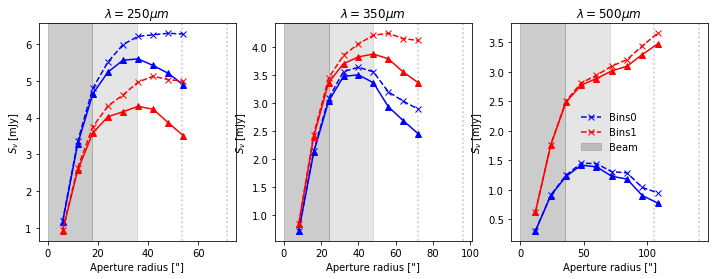

In [5]:
ph_mean = []
ph_mean2 = []
cols = {0:'b', 1:'r', 2:'g', 3:'y', 4:'k', 5:'c'}
j=1
fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for idz in xrange(len(zbins)):
        for i in xrange(1,rmax+1):
            ph_mean.append(GetTotPhotometryFromStacks(lambda_, idz, i, r_in=3*psf[lambda_]/reso[lambda_], r_out=4*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=15))
            ph_mean2.append(GetTotPhotometryFromStacks(lambda_, idz, i, remove_mean=True, remove_max=15))
        
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'--x', label='Bins' + str(idz), color=cols[idz])
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'-^', color=cols[idz])

        ph_mean = []
        ph_mean2 = []
              

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)

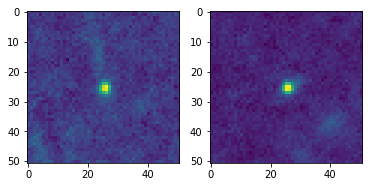

In [6]:
l = 250
plt.subplot(121)
plt.imshow(np.concatenate([sims[l][patch][0].copy() - bkd[l][patch][0].mean() for patch in patches], axis=0).mean(0))
plt.subplot(122)
plt.imshow(np.concatenate([sims[l][patch][1].copy() - bkd[l][patch][1].mean() for patch in patches], axis=0).mean(0))

In [91]:
for i in xrange(2):
    print np.sum([sims[500][p][i].shape[0] for p in patches])

1598
7028


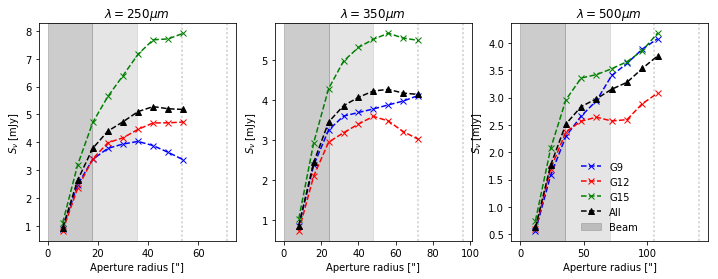

In [7]:
def GetPhotometryFromStacks(lambda_, zbin, patch, r, r_in=None, r_out=None, remove_mean=True, remove_max=0):
#     simuls = {}
#     simuls[patch] = sims[lambda_][patch][zbin].copy()
    simuls = sims[lambda_][patch][zbin].copy()

    if remove_max > 0:
        for _ in xrange(remove_max):
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
       
    if (r_in is None) or (r_out is None):
        apertures = CircularAperture(positions[lambda_], r=r)
        if remove_mean:
            stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = simuls.mean(axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
    else:
        apertures = CircularAperture(positions[lambda_], r=r)
        annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
        apers = [apertures, annulus_apertures]
        if remove_mean:
            stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = simuls.mean(axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['aperture_sum'] = final_sum
    return phot_table.field('aperture_sum')[0]

ph_mean = []
ph_mean2 = []
cols = {'G9':'b', 'G12':'r', 'G15':'g'}
j=1
zbin = 1

fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for patch in patches:
        for i in xrange(1,rmax+1):
            ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, r_in=3*psf[lambda_]/reso[lambda_], r_out=4*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'--x', label=patch, color=cols[patch])
        ph_mean = []
        ph_mean2 = []
          
    for i in xrange(1,rmax+1):
        ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, r_in=3*psf[lambda_]/reso[lambda_], r_out=4*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
    
    plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'--^', label='All', color='k')

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)
    

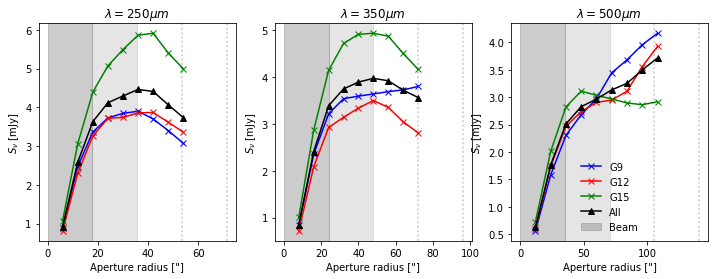

In [9]:
ph_mean = []
ph_mean2 = []
cols = {'G9':'b', 'G12':'r', 'G15':'g'}
j=1
zbin = 1
rmax = 9

fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for patch in patches:
        for i in xrange(1,rmax+1):
            ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, remove_mean=True, remove_max=10))
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'-x', label=patch, color=cols[patch])
        ph_mean = []
        ph_mean2 = []
          
    for i in xrange(1,rmax+1):
        ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, remove_mean=True, remove_max=10))
    
    plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'-^', label='All', color='k')

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)